**ЗАДАНИЕ:**

Обученная модель должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

**МЕТРИКА:**

Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.

Для начала импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import category_encoders as ce

from sklearn import preprocessing
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
# зафиксируем версию пакетов, для воспроизводимы воспроизводимости экспериментов:
!pip freeze > requirements.txt

Загружаем данные

In [65]:
# данные из соревнования
DATA_DIR = '../../Projects/PROJECT3. ML-hotels/data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [66]:
# фиксируем RANDOM_SEED и TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.25

### Посмотрим на данные:
у нас есть тренировочный датасет df_train, который содержит 17 признаков и тестовый датасет df_test, который содержит те же колонки, что и тренировочный датасет, кроме признака reviewer_score*, мы его должны предсказать.

sample_submission - содержит рейтинг и id* отеля.

* hotel_address — адрес отеля;

* review_date — дата, когда рецензент разместил соответствующий отзыв;

* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

* hotel_name — название отеля;

* reviewer_nationality — страна рецензента;

* negative_review — отрицательный отзыв, который рецензент дал отелю;

* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

* positive_review — положительный отзыв, который рецензент дал отелю;

* review_total_positive_word_counts — общее количество слов в положительном отзыве;

* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

* total_number_of_reviews — общее количество действительных отзывов об отеле;

* tags — теги, которые рецензент дал отелю;

* days_since_review — количество дней между датой проверки и датой очистки;

* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

* lat — географическая широта отеля;
* lng — географическая долгота отеля.

объединим в один датасет и добавим маркеры, где 1 - Обозначаем тренировочные данные; 2 - Обозначаем тестовые данные

In [67]:
# Добавляем маркеры
df_train['dataset'] = 1  # Обозначаем тренировочные данные
df_test['dataset'] = 0    # Обозначаем тестовые данные
df_test['reviewer_score'] = 0  # Заполняем оценку нулями, так как ее нет

# Объединяем датасеты
hotels = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Описательный анализ данных

In [68]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,dataset
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


In [69]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [70]:
hotels.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel_address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additional_number_of_scoring,515738.0,NaN,NaN,NaN,498.081836,500.538467,1.0,169.0,341.0,660.0,2682.0
review_date,515738,731,8/2/2017,2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_score,515738.0,NaN,NaN,NaN,8.397487,0.548048,5.2,8.1,8.4,8.8,9.8
hotel_name,515738,1492,Britannia International Hotel Canary Wharf,4789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_nationality,515738,227,United Kingdom,245246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_review,515738,330011,No Negative,127890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,515738.0,NaN,NaN,NaN,18.53945,29.690831,0.0,2.0,9.0,23.0,408.0
total_number_of_reviews,515738.0,NaN,NaN,NaN,2743.743944,2317.464868,43.0,1161.0,2134.0,3613.0,16670.0
positive_review,515738,412601,No Positive,35946,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Очистка данных

Посмотрим на количество пропущенных значений в столбцах

In [71]:
null_counts = hotels.isnull().sum()
null_counts

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dataset                                          0
dtype: int64

Заметим что только в столбцах lat и lng есть пропущенные значения

Заполняем пропуски

In [72]:
# создадим словарь отелей и координат которые не были заполнены, где ключ - название отеля, кортеж координат - это значение. 
# 17 пропущенных значений, мы можем заполнить координаты достаточно точно

coords_dict = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': (48.221415,
  16.2874559),
 'City Hotel Deutschmeister': (48.2211573, 16.3620293),
 'Cordial Theaterhotel Wien': (48.2098335, 16.3475615),
 'Derag Livinghotel Kaiser Franz Joseph Vienna': (48.2462468,
  16.3387236),
 'Fleming s Selection Hotel Wien City': (48.2098335, 16.3475615),
 'Holiday Inn Paris Montmartre': (48.8888806, 2.3331948),
 'Hotel Advance': (41.3832344, 2.162940206993912),
 'Hotel Atlanta': (48.2203284, 16.3558289),
 'Hotel City Central': (48.2278937, 16.3882026),
 'Hotel Daniel Vienna': (48.1888627, 16.3838516356697),
 'Hotel Park Villa': (48.2331682, 16.3470804),
 'Hotel Pension Baron am Schottentor': (48.2212841, 16.3546402),
 'Maison Albar Hotel Paris Op ra Diamond': (48.875248, 2.3233746),
 'Mercure Paris Gare Montparnasse': (48.839701, 2.323519),
 'NH Collection Barcelona Podium': (41.3929354, 2.1758883),
 'Renaissance Barcelona Hotel': (41.3927154, 2.1674921),
 'Roomz Vienna': (48.18672145, 16.420653090404993)} 

Создадим промежуточный датафрейм чтобы с помощью него заполнить пропуски

In [73]:
hotels_nulls = hotels.loc[hotels['lat'].isna(), ['hotel_name', 'lat', 'lng']]

создадим функцию для заполнения пропусков в столбцах lat,lng

In [74]:
def fill_lat_lng(row):
    # row — это одна строка датафрейма hotels_nulls
    hotel_name = row['hotel_name']  # Достаем название отеля
    lat, lng = coords_dict.get(hotel_name, (None, None))  # Получаем координаты из словаря
    return pd.Series([lat, lng])  # Возвращаем две колонки

# Применяем функцию к строкам, заполняем пропуски координатами
hotels_nulls[['lat', 'lng']] = hotels_nulls.apply(fill_lat_lng, axis=1)

In [75]:
# заполянем пропущенные значения новыми координатами по индексам
hotels.update(hotels_nulls)

удаляем столбец с названием отеля, так как он нам больше не нужен

In [76]:
hotels_nulls.drop(columns='hotel_name', inplace=True)

посмотрим теперь нет ли пропущенных значений

In [77]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. Создание новых признаков

Теперь когда нет пропусков в столбцах, создадим новый признак "расстояние до центра города"

Для начала из признака с адресами отеля выделим "город"

In [78]:
def get_city(address):
    # Оставляем только те слова, длина которых больше 4, чтобы убрать зип код
    lst_address = [item for item in address.split() if len(item)>4]
   
    # Проверяем, если это United Kingdom, то возвращаем 3 слово с конца
    if lst_address[-1] == 'Kingdom':
        return lst_address[-3]
    else:
        return lst_address[-2]
    
hotels['hotel_city'] = hotels['hotel_address'].apply(get_city)

посмотрим на распределение городов

Text(0.5, 1.0, 'Распределение количества отелей по городам')

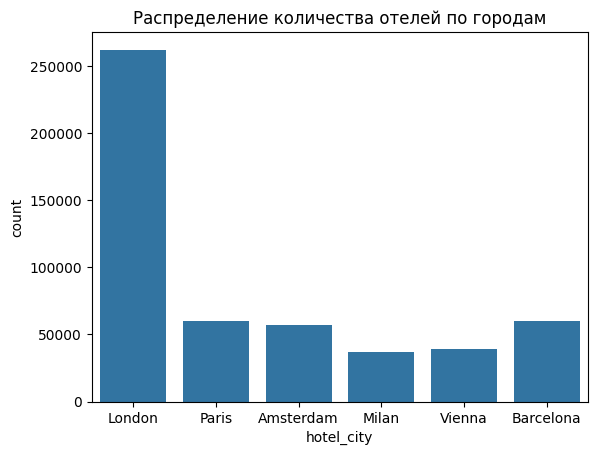

In [79]:
sns.countplot(x=hotels['hotel_city'])
plt.title('Распределение количества отелей по городам')

По графику видно, что большинство отелей находятся в Лондоне — их чуть более 250 тысяч, что составляет примерно половину всех данных в датафрейме.

Создадим словарь с координатами центра города

In [80]:
centre_coords_city = {'Milan': (45.4641943, 9.1896346),
 'Amsterdam': (52.3730796, 4.8924534),
 'Barcelona': (41.3828939, 2.1774322),
 'London': (51.5073359, -0.12765),
 'Paris': (48.8588897, 2.3200410217200766),
 'Vienna': (48.2083537, 16.3725042)}

Теперь с помощью библиотеки geopy рассчитаем расстояние от отеля до центра города

In [81]:
from geopy.distance import geodesic # Импортируем библотеку для рассчета расстояния

# Функция для нахождения расстояния от центры до отеля в км
def distance_to_center(row):
    city = row['hotel_city'] # Записываем в эту переменную название города
    hotel_coords = (row['lat'], row['lng']) # Записываем координаты
    city_coords = centre_coords_city[city] # Здесь мы обращаемся к нашему словарб и записываем координаты центра города
    distance_km = geodesic(hotel_coords, city_coords).km # Считаем расстояние
    
    return distance_km # Возвращаем значение

In [82]:
# Создаем новый признак расстояние от центра до отеля
hotels['distance_to_city_center'] = hotels.apply(distance_to_center, axis=1)

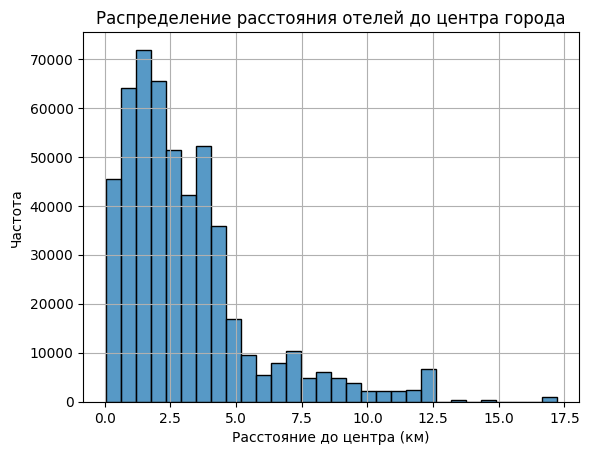

In [83]:
# Построим гистограмму признака расстояние от отеля до центра
sns.histplot(hotels['distance_to_city_center'], bins=30)
plt.title('Распределение расстояния отелей до центра города')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

На графике видно, что большинство отелей находятся примерно в двух киллометрах от центра. Можно даже сказать что основная масса находится в 5 киллометрах от центра, а вот потом уже можно заметить как концентрация снижается и есть "хвост" на расстоянии 17,5 км

Теперь создадим признак "страна"

In [84]:
# Функция для извлечения страны
def get_country(address):
    # Выделяем страну из адреса отеля
    country = address.split()[-1]
    if country == 'Kingdom':
        return 'UK'
    else:
        return country

# Применим функцию к столбцу с адресом
hotels['hotel_country'] = hotels['hotel_address'].apply(get_country)

Text(0.5, 1.0, 'Распределение отелей по странам')

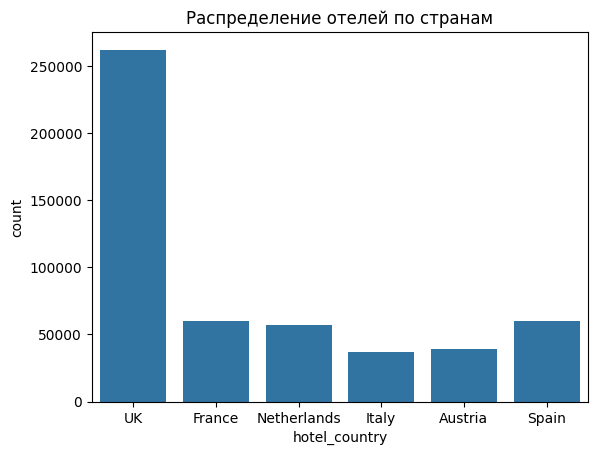

In [85]:
# Построим график распределения отелей по странам
sns.countplot(data=hotels, x='hotel_country')
plt.title('Распределение отелей по странам')

Так как у нас на одну страну - один город, то этот график полностью совпадает с графиком городов, и скорее всего один из них мы в дальнейшем удалим из-за мультиколлинеарности. Большинство отелей из Великобритании, а именно около половины всех данных

Посмотрим когда был оставлен самый свежий и и первый отзыв

In [86]:
# Приведем дату оценки к типу datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [87]:
print(f'Самый свежий отзыв был оставлен: {hotels["review_date"].dt.date.max()}')
print(f'Самый первый отзыв был оставлен: {hotels["review_date"].dt.date.min()}')

Самый свежий отзыв был оставлен: 2017-08-03
Самый первый отзыв был оставлен: 2015-08-04


Создадим теперь признак "год"

In [88]:
# Выделим признак год из даты оценки
hotels['review_year'] = hotels['review_date'].dt.year

Text(0.5, 1.0, 'Распределение количества отзывов по годам')

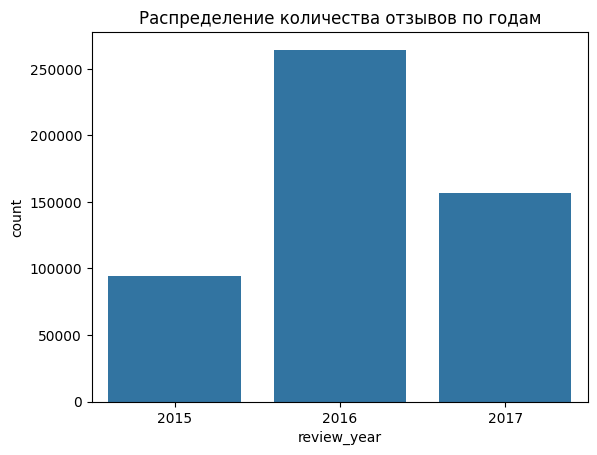

In [89]:
# Построим гистограмму 
sns.countplot(data=hotels, x='review_year')
plt.title('Распределение количества отзывов по годам')

Большинство оценок было сделано в 2016 году.

Создадим признак месяц

In [90]:
# Выделим признак месяца из даты оценки
hotels['review_month'] = hotels['review_date'].dt.month

Text(0.5, 1.0, 'Распределение количества отзывов по месяцам')

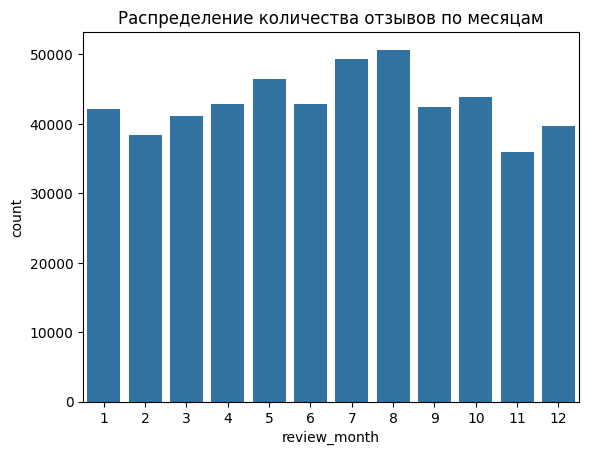

In [91]:
# Посмотрим на распределение
sns.countplot(data=hotels, x='review_month')
plt.title('Распределение количества отзывов по месяцам')

Заметим, что большинство оценок были сделаны в шестом и седьмом месяце(июнь и июль соответственно). А вот меньше всего оценок было сделано в 11 месяце(в ноябре). Имеет ли это статистический вес или же случайность, предстоит проверить далее 

Создадим признак день недели

In [92]:
# Выделим признак "день недели" из даты оценки
hotels['review_day'] = hotels['review_date'].dt.dayofweek 

Text(0.5, 1.0, 'Распределение отзывов по дням недели')

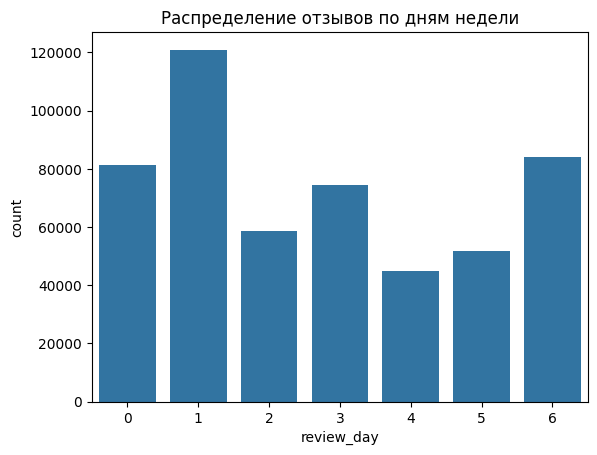

In [93]:
# Визуализируем 
sns.countplot(data=hotels, x='review_day') # 0-Понедельник, 6-воскресенье
plt.title('Распределение отзывов по дням недели')

Большинство отзывов были оставлены во вторник

Создадим признак сезонность

In [94]:
# Создадим ф-ю для определния сезонности и применим к столбцу с месяцами оценки
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Применим нашу функцию к столбцу с месяцами оценки
hotels['season'] = hotels['review_month'].apply(get_season)

Text(0.5, 1.0, 'Распределние оценок по сезонам')

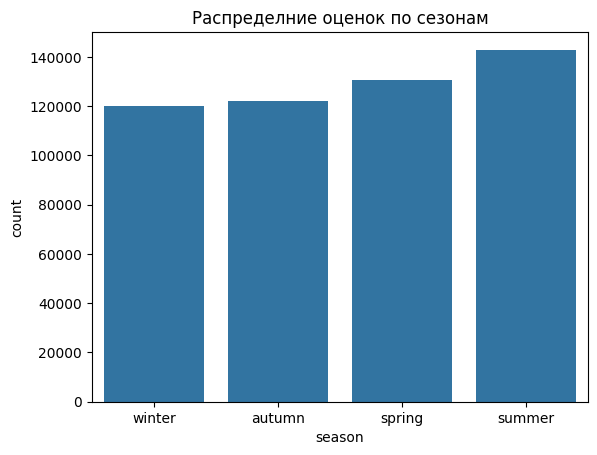

In [95]:
# Визуализируем
sns.countplot(x=hotels['season'])
plt.title('Распределние оценок по сезонам')

Выделим признак количества ночей 

In [96]:
import ast

hotels['tags'] = hotels['tags'].apply(ast.literal_eval)

# Создадим функцию для поиска кол-ва ночей из тегов
def get_nights(tag):
    for item in tag: # Проходимся циклов по тегу
        words = item.strip().split() # Записываем в переменную words каждый тег
        if len(words) == 3 and 'night' in item: # Проверяем есть ли night в теге
            return int(item.split()[1]) # Возвращаем кол-во ночей 
    return 1  # Если тег кол-во ночей не указан, возвращаем 1 

hotels['nights_in_hotel'] = hotels['tags'].apply(get_nights) # Применяем нашу функцию к столбцу с тегами

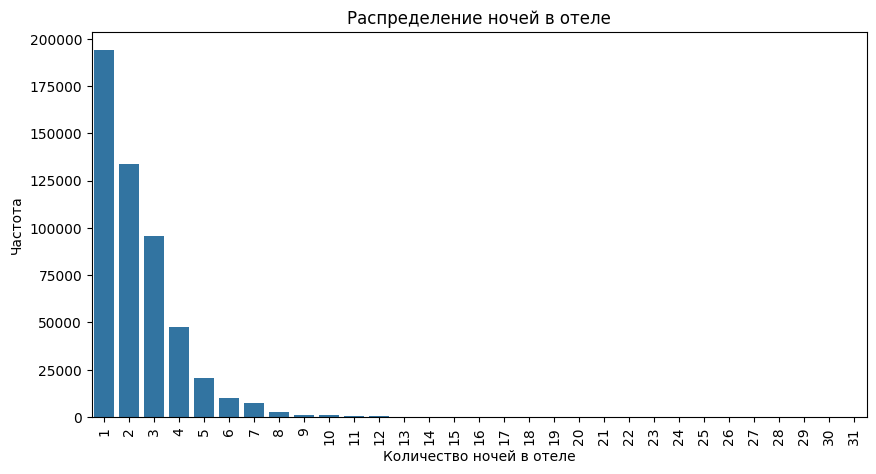

In [97]:
# Визуализируем распределения кол-ва ночей в отеле
plt.figure(figsize=(10, 5))
sns.countplot(x=hotels['nights_in_hotel']) # Строим график countplot
plt.xlabel("Количество ночей в отеле") # Название оси х
plt.ylabel("Частота") # Название оси y
plt.title("Распределение ночей в отеле") # Название графика
plt.xticks(rotation=90) # чтобы надписи по оси х были 90 градусов
plt.show()

В основном оценщики останавливались на одну ночь. Также видно тенденцию, чем больше дней, тем меньше оценщиков выбирали именно столько ночей.

Создадим признак тип поездки

In [98]:
# Функци для того, чтобы выделить тип поездки из тегов
def get_type_trip(tag):
    for item in tag: # Прозодимся по циклу
        if 'trip' in item: # Если встречаем "trip" 
            return item.strip() # Возвращаем весь тег 
    return 'unknown_trip' # Если нет "trip" возвращаем "unknown_trip"

# Применяем функцию к столбцу с тегами
hotels['type_of_trip'] = hotels['tags'].apply(get_type_trip) 

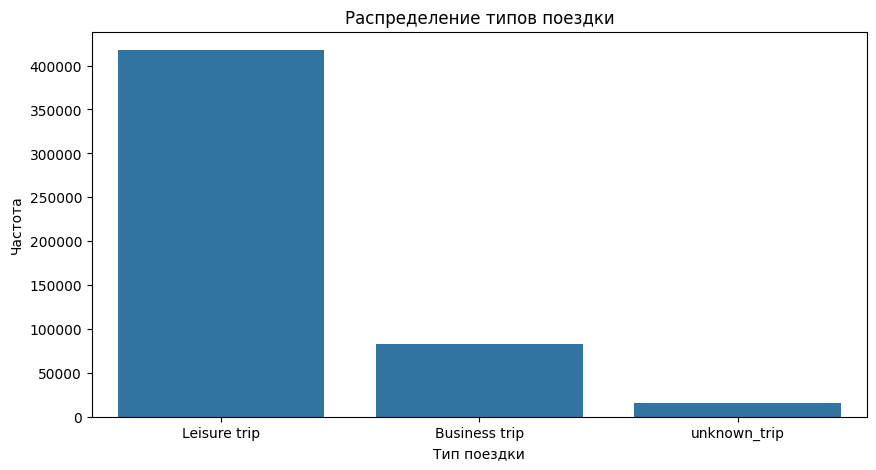

In [99]:
# Визуализируем распределение типов поездки
plt.figure(figsize=(10, 5))
sns.countplot(x=hotels['type_of_trip']) # Строим график countplot
plt.title('Распределение типов поездки') # Устанавливаем название графика
plt.xlabel('Тип поездки') # Устанавливаем название оси х
plt.ylabel('Частота') # Устанавливаем название оси y
plt.show()

### Большинство оценщиков останавливались в отеле именно для отдыха (больше 400 тысяч), другая часть была в командировке(почти 100 тысяч). Еще есть малая часть у кого тип поездки не указан(unknown_trip)

Интересно проверить, есть ли зависимость между количеством ночей в отеле и типом поездки. Логично предположить, что командировки обычно краткосрочные (1-2 ночи), тогда как отдых предполагает более длительное пребывание

In [100]:
# Группируем данные 
grouped = hotels.groupby(by=['type_of_trip', 'nights_in_hotel'])['reviewer_nationality'].agg(['count']).reset_index()

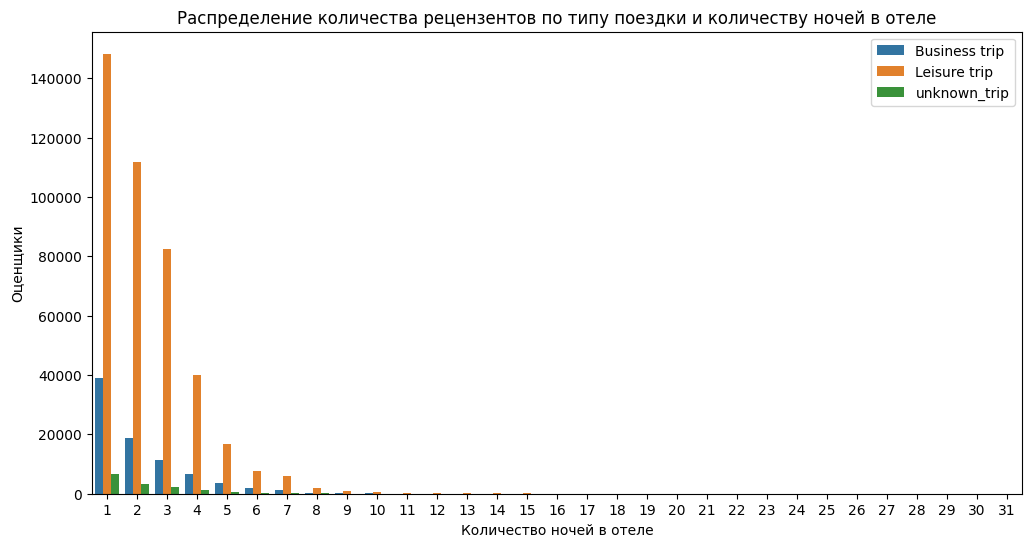

In [101]:
# Визуализируем наш сформированный датафрейм
plt.figure(figsize=(12, 6))  # Размер графика
sns.barplot(x='nights_in_hotel', y='count', hue='type_of_trip', data=grouped) # Столбчатая диаграмма
plt.title('Распределение количества рецензентов по типу поездки и количеству ночей в отеле') # Название графика
plt.xlabel('Количество ночей в отеле') # Название по оси Х
plt.ylabel('Оценщики') # Название по оси Y
plt.legend(loc='upper right') # Параметр, отвечающий за расположение легенды
plt.show()

По графику можно заметить, что на одну ночь оставалось больше оценщиков именно с целью отдыха(больше 140 тысяч). И в принципе распределение по остальным ночам примерно равномерное(относительно первой ночи, то есть большинство оставалось с целью отдохнуть и лишь малая часть была в командировке), и не важно, отдых это или командировка. Так что моя мысль тут опровергается. Просто было интересно посмотреть, есть ли зависимость.

Выделим признак окраска отзыва # 1: позитивный, 0: нейтральный -1: негативный

In [102]:
# Импортируем библиотеки
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Создаем объект, который будет оценивать тональность текста
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rodinilya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Создадим функцию для оценки тональности негативных отзывов

In [103]:
def get_negative_score(negative_review):
    # Преобразуем строку к нижнему регистру и удаляем лишние пробелы
    negative_review = negative_review.lower().strip()

    # Если негатив отсутствует, присваиваем 1 (то есть нет негативных моментов)
    if negative_review in ['no negative', 'nothing', 'none', 'n a', 'nothing really', 'all good']:
        return 1

    # Если отзыв полностью отрицательный, например "everything", ставим -1
    if negative_review == 'everything':
        return -1

    # Создаем множество ключевых негативных слов
    negative_keywords = {'bad', 'dirty', 'poor', 'worst', 'uncomfortable', 'terrible', 'awful', 'horrible',
                         'disgusting', 'noisy', 'rude', 'broken', 'unpleasant', 'smelly', 'slow', 'unfriendly'}  

    # Если в отзыве есть явные негативные слова, рассчитываем его тональность
    if any(word in negative_review for word in negative_keywords):
        return round(sent_analyzer.polarity_scores(negative_review)['compound'], 3)

    # Добавляем отрицательный окрас, если отзыв нейтральный, но явно негативный по контексту
    modified_review = 'bad ' + negative_review
    return round(sent_analyzer.polarity_scores(modified_review)['compound'], 3)

# Применяем функцию к столбцу с негативными отзывами
hotels['negative_review_score'] = hotels['negative_review'].apply(get_negative_score)

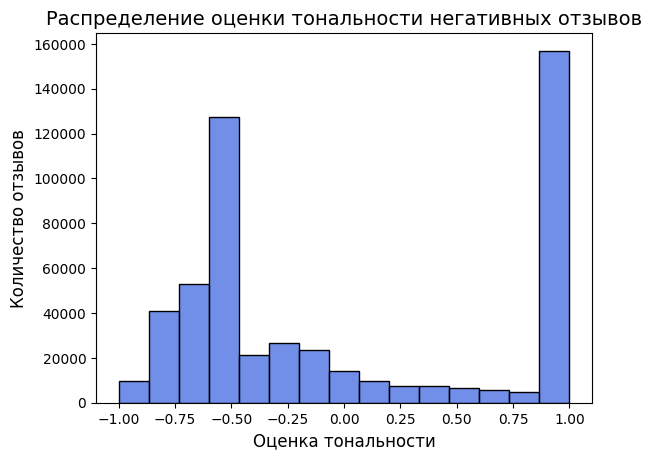

In [104]:
# Визуализируем
sns.histplot(hotels['negative_review_score'], bins=15, color='royalblue') # Настраиваем гистограмму 
plt.title('Распределение оценки тональности негативных отзывов', fontsize=14) # Название графика
plt.xlabel('Оценка тональности', fontsize=12) # Название по оси Х
plt.ylabel('Количество отзывов', fontsize=12) # Название по оси Y
plt.show()

Заметим, что например "Nothing" в негативном отзыве дает положительный окрас комментарию. Большинство наблюдений сосредоточены близ единицы. Если рассматривать негативный окрас, то большинство налюдений сосредоточены близ значения -0.5. Отзывов с негативным окрасом в -1 совсем мало меньше 10 процентов

Создадим функцию для оценки тональности позитивных отзывов

In [105]:
def get_positive_score(positive_review):
    # преобразовываем строку к нижнему регистру и удаляем лишние пробелы
    positive_review = positive_review.lower().strip()

    # Отсутствие негатива ставим -1
    if positive_review in['nothing', 'n a', 'no positive', 'na', 'none', 'nothing really']:
        return -1
    
    # Создаем множество с ключевыми позитивными словами
    positive_keywords = {'comfy', 'great', 'good', 'excellent', 'amazing', 'friendly', 'wonderful', 'perfect',
                         'awesome', 'superb', 'nice', 'cozy', 'fantastic', 'pleasant', 'love', 'beautiful'} 
    
    # Проверяем есть слово everything возрващаем 1
    if 'everything' in positive_review:
        return 1
    
    # Проверяем есть ли в отзыве позитивные слова
    if any(word in positive_review for word in positive_keywords):
        return round(sent_analyzer.polarity_scores(positive_review)['compound'], 3)
    
    # Если в отзыве нет позитивных слов, добавляем положительный окрас с помощью good, так как это положительный отзыв и просто location в отзыве это явно положительно
    modified_review  = 'good' + positive_review
    return round(sent_analyzer.polarity_scores(modified_review)['compound'], 3)

hotels['positive_review_score'] = hotels['positive_review'].apply(get_positive_score) 

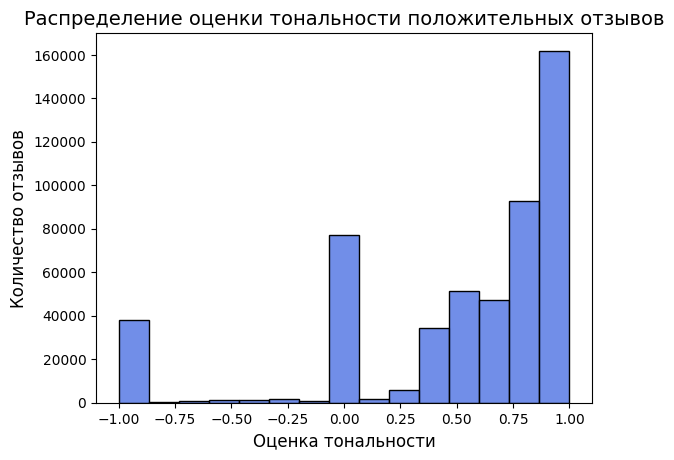

In [106]:
# Визуализируем
sns.histplot(hotels['positive_review_score'], color='royalblue', bins=15) # Настраиваем саму гистрограмму
plt.title('Распределение оценки тональности положительных отзывов', fontsize=14) # Название графика
plt.xlabel('Оценка тональности', fontsize=12)  # Название оси X (1 - положительный, 0 - нейтральный, -1 - негативный)
plt.ylabel('Количество отзывов', fontsize=12) # Название оси Y
plt.show()

Большинство отзывов сосредоточены близ единицы. Также можно отметить, если сравнивая с негативными отзывами, то тут намного больше нейтральных отзывов(почти в 4 раза больше). Негативных отзывов также больше(почти в два раза) 

Построим сводную табличку по странам и негативным отзывам

In [107]:
# Группируем данные
grouped_negative = hotels.groupby('reviewer_nationality')['negative_review_score'].agg(['count', 'mean']).sort_values(by='mean', ascending=True) 

# Преобразовывам столбец 'mean' к двум знакам после запятой
grouped_negative['mean'] = grouped_negative['mean'].round(2)

Возьмем только те национальности, у которых кол-во отзывов больше 1000

In [108]:
filtered_negative = grouped_negative[grouped_negative['count'] > 1000]

Визуализируем нашу сводную таблицу

In [109]:
# Из библиотеки plotly импортируем модель express 
import plotly.express as px

# Настраиваем фигуру
fig = px.bar(
    filtered_negative.head(15), 
    x=filtered_negative.head(15).index, 
    y='mean', 
    text='count',  # Показываем количество отзывов при наведении
    opacity=0.6
)

# Настроим внешний вид
fig.update_layout(
    title='Распределение значения средней тональности (негатив) по национальности (Топ-15)',
    xaxis_title='Национальность',
    yaxis_title='Средняя оценка',
    xaxis_tickangle=-45
)

fig.show()

На графике видно, что самые низкие средние оценки (среди национальностей с более чем 1000 отзывами) дают представители Омана. Однако все значения находятся вблизи нуля, что указывает скорее на нейтральный тон отзывов, чем на выраженный негатив. Таким образом, можно сделать вывод, что среди представленных национальностей нет явных лидеров по количеству негативных оценок.

Также посмотрим на топ 15 позитивных отзывов по значению средней оценки в разрезе национальностей

In [110]:
# Группируем данные
grouped_positive = hotels.groupby('reviewer_nationality')['positive_review_score'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)
# Преобразовываем столбец к двум знакам после запятой
grouped_positive['mean'] = grouped_positive['mean'].round(2)

Выделим только те национальности, у которых кол-во отзывов больше 100 для наглядности

In [111]:
filtered_positive = grouped_positive[grouped_positive['count'] > 1000]

Визуализируем нашу сводную таблицу

In [112]:
# Настраиваем фигуру
fig = px.bar(
    filtered_positive.head(15), 
    x=filtered_positive.head(15).index, 
    y='mean', 
    text='count',  # Показываем количество отзывов при наведении
    opacity=0.6
)

# Настроим внешний вид
fig.update_layout(
    title='Распределение значения средней тональности (негатив) по национальности (Топ-15)',
    xaxis_title='Национальность',
    yaxis_title='Средняя оценка',
    xaxis_tickangle=-45
)

fig.show()

На графике видно, что самую высокую среднюю оценку (0.6) ставят оценщики из Новой Зеландии. В целом распределение оценок выглядит достаточно равномерным (если рассматривать топ-15). Наименьшую среднюю оценку в этом списке – 0.5 – ставят представители Китая. Интересно отметить, что оценщики из Великобритании в среднем ставят 0.53, и учитывая их количество (250 тысяч), это весьма значимый результат.

# 3. Кодирование категориальных признаков

Посмотрим на столбцы с типом данных "object"

In [113]:
hotels.select_dtypes(include='object').columns

Index(['hotel_address', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'positive_review', 'tags', 'days_since_review',
       'hotel_city', 'hotel_country', 'season', 'type_of_trip'],
      dtype='object')

Первым делом закодируем признаки с помощью OneHotEncoder(), где кол-во признаков не будет составлять > 20

In [114]:
# Создаем объект класса OneHotEncoder()
ohe = ce.OneHotEncoder(cols=['season', 'hotel_city', 'hotel_country', 'type_of_trip'], use_cat_names=True)
# Применяем One-Hot Encoding к столбцу 'season'
data_ohe = ohe.fit_transform(hotels[['season', 'hotel_city', 'hotel_country', 'type_of_trip']])

In [115]:
# Объединяем с основным датафреймом
hotels = pd.concat([hotels, data_ohe], axis=1)

Следующим будем кодировать национальность оценщика, но так как очень много уникальных категорий будем использовать BinaryEncoder()

In [116]:
# Создаем объект класса BinaryEncoder()
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
# Применяем BinaryEncoder к столбцу 'reviewer_nationality'
bin_data = bin_enc.fit_transform(hotels['reviewer_nationality'])

In [117]:
# Объединяем с основным датафреймом
hotels = pd.concat([hotels, bin_data], axis=1)

Удалим нечисловые столбцы, которые уже закодировали или из которых выделили нужные нам признаки

In [118]:
hotels.drop(['hotel_address', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'positive_review', 'tags', 'days_since_review',
       'hotel_city', 'hotel_country', 'season', 'type_of_trip', 'review_date'], axis=1, inplace=True)

In [119]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   dataset                                     515738 non-null  int64  
 

Теперь все признаки в числовом формате и мы можем спокойно обучать нашу модель

# 4. Анализ мультиколлинеарности

### Разделим данные на категориальные и числовые

Выделим категориальные столбцы

In [120]:
cat_cols = hotels.iloc[:, 17:]

Построим тепловую карту корреляции

<Axes: >

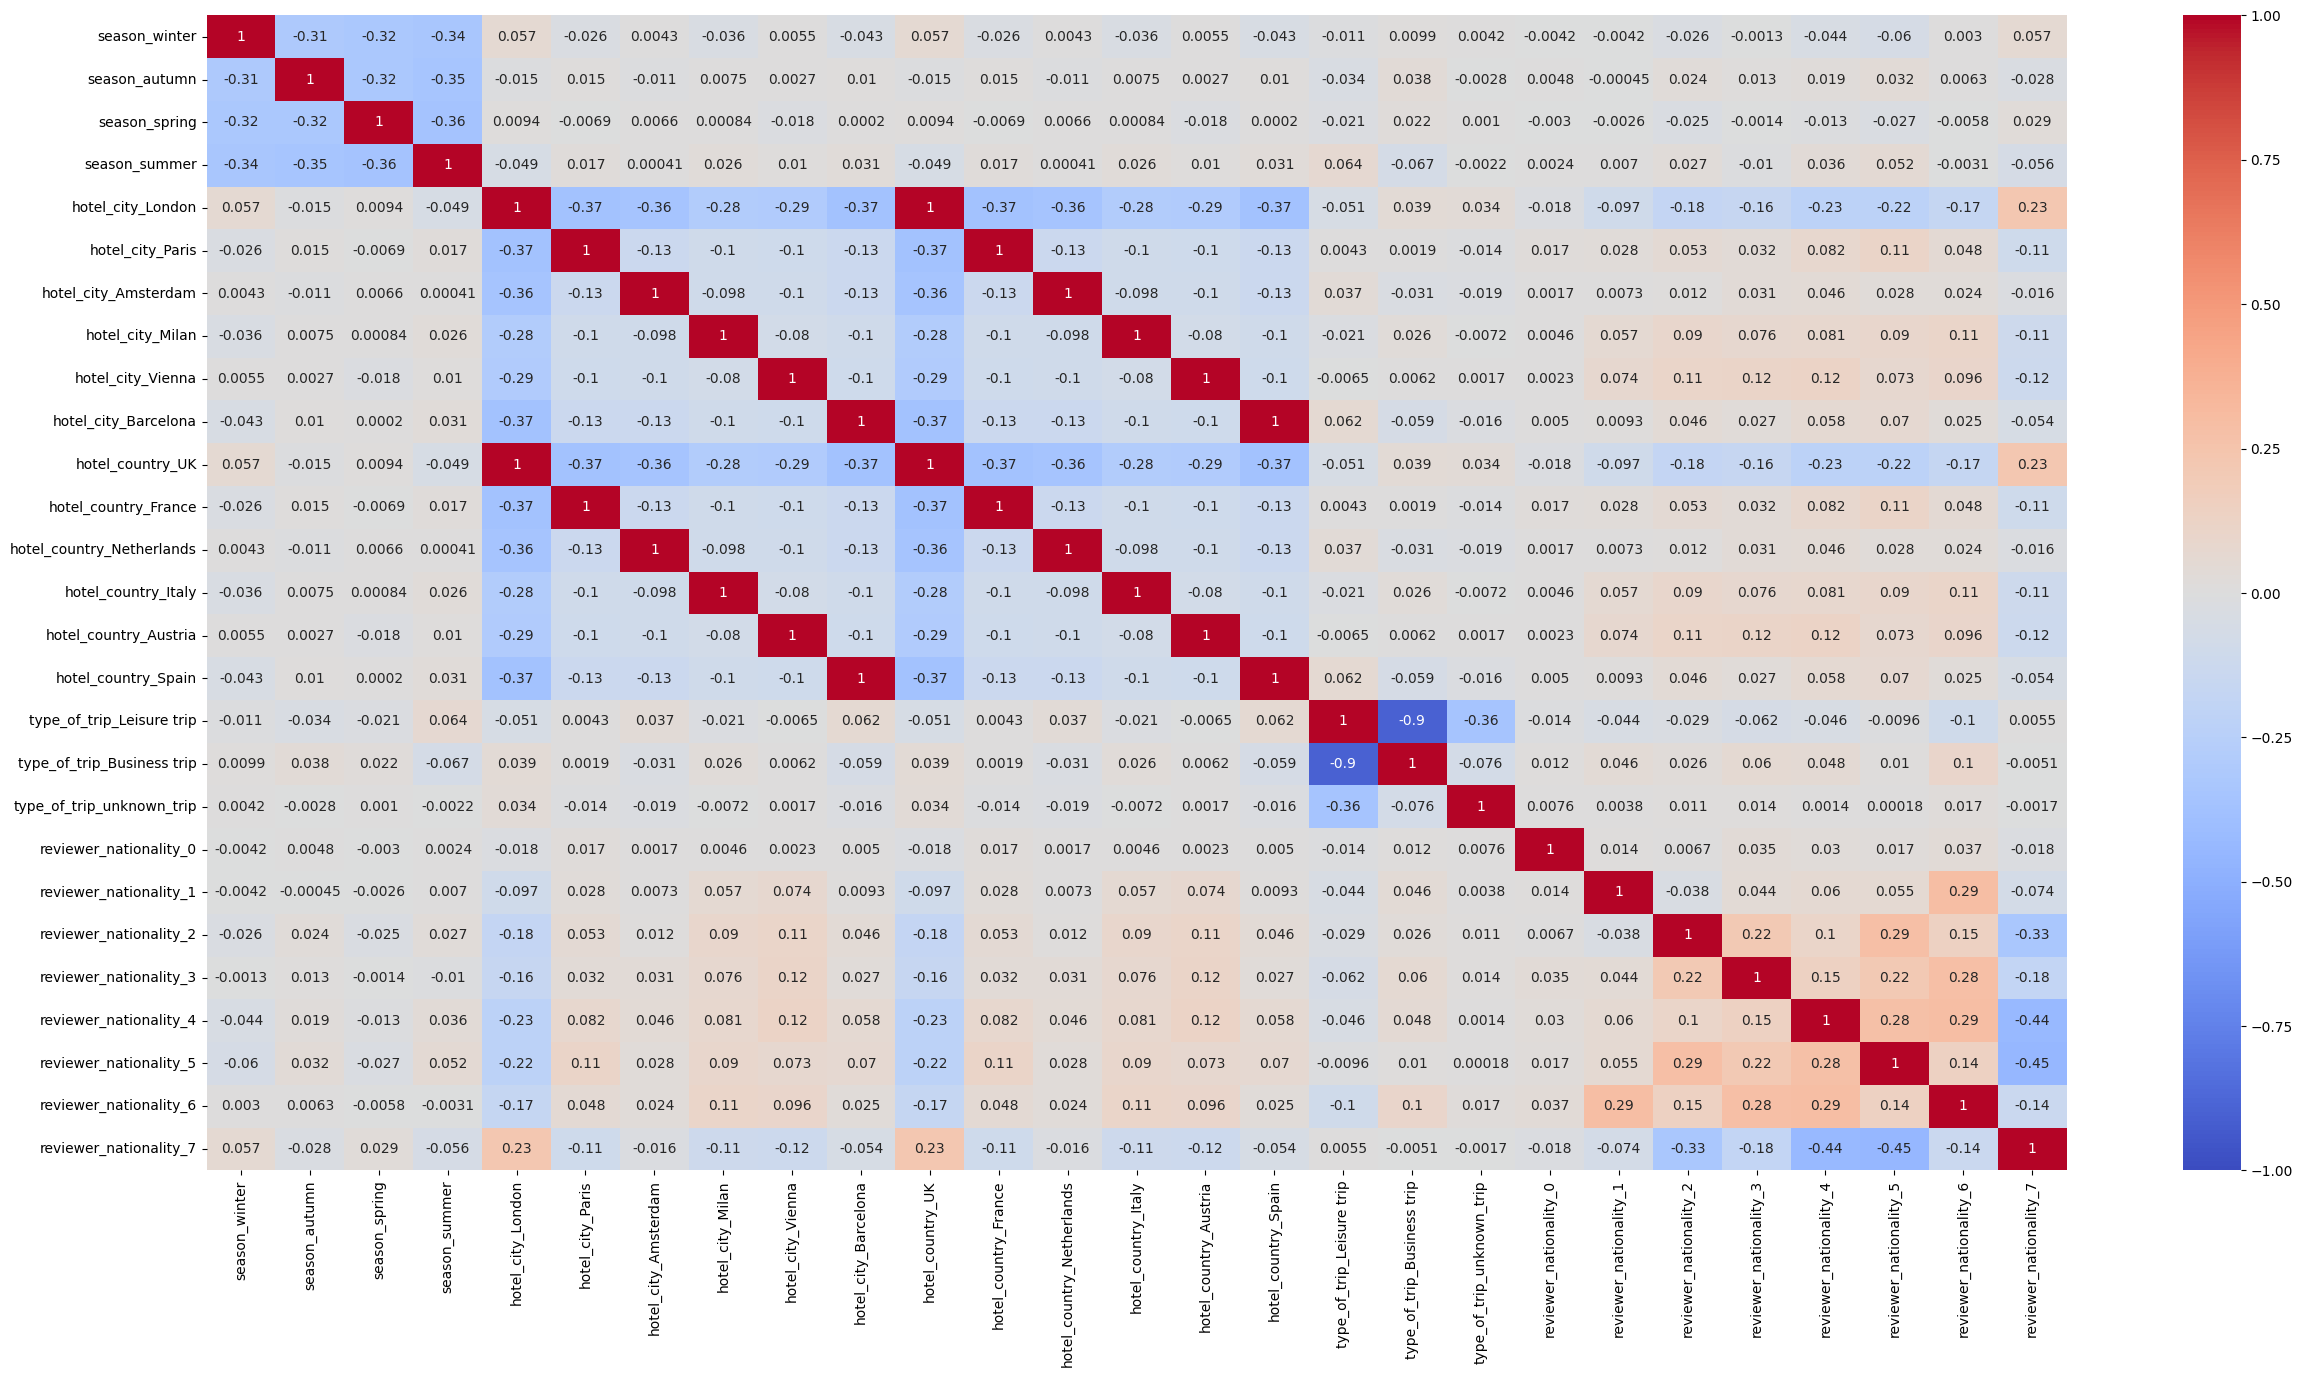

In [121]:
plt.figure(figsize=(30, 15))
sns.heatmap(cat_cols.corr(method='spearman'), cmap='coolwarm', vmin=-1, annot=True)

Cильную корреляцию(мультиколлинеарность) имеют признаки стран и городов, а также Тип поезки Leisure Trip и Business Trip

Выделим числовые столбцы

In [122]:
num_cols = hotels.iloc[:, :17]

Построим тепловую карту корреляции числовых признаков

<Axes: >

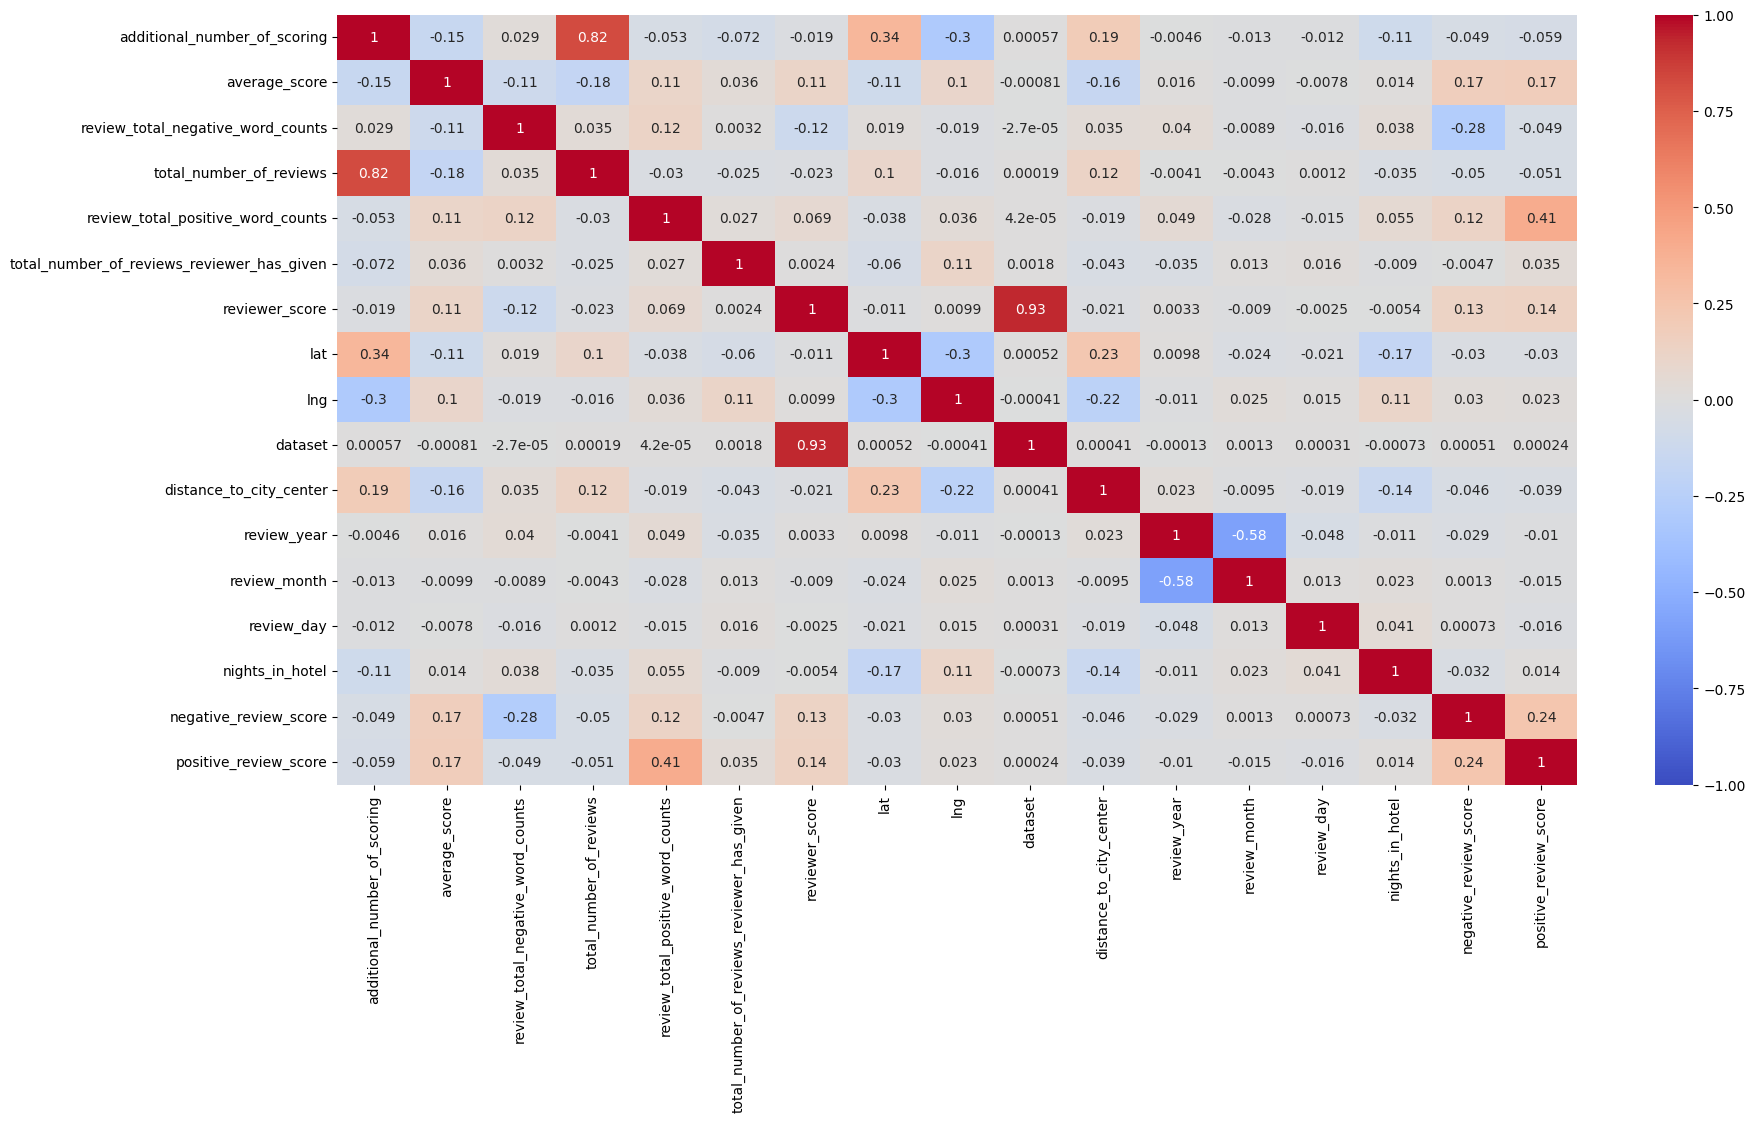

In [123]:
plt.figure(figsize=(20, 10))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm', vmin=-1)

Отметим, что сильную корреляцию имеют признаки общее "количество действительных отзывов об отеле" и "действительные оценок без проверки", также месяц оценки и год имеет корреляцию -0.58, но так как мы выделили признак сезонности, признак "review_month" можем удалить

Теперь удалим столбцы в исходном датафрейме

In [124]:
cols_to_drop = ['total_number_of_reviews', 'review_month', 'hotel_city_London', 
                'hotel_city_Paris', 'hotel_city_Amsterdam', 'hotel_city_Milan', 'hotel_city_Vienna', 
                'hotel_city_Barcelona', 'type_of_trip_Business trip'] # Столбцы, которые будем удалять

hotels.drop(columns=cols_to_drop, inplace=True) # Удаляем столбцы в исходном датафрейме

Также удалим признак долготы и широты, так как без доп расчетов данный признак не имеет значения. Плюс мы уже выделили расстояние до центра города и страну

In [125]:
hotels.drop(columns=['lat', 'lng'], inplace=True)

Посмотрим теперь на столбцы в датасете

In [126]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   dataset                                     515738 non-null  int64  
 7   distance_to_city_center                     515738 non-null  float64
 8   review_year                                 515738 non-null  int32  
 9   review_day                                  515738 non-null  int32  
 

На данный момент осталось 33 признака (включая признак-мигалку "датасет" и целевой признак)

# 5. Отбор признаков на основе их важности

Разделяем признаки на категориальные и числовые

In [127]:
# Числовые признаки
num_features = [
    'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
    'distance_to_city_center', 'review_year', 'review_day', 'nights_in_hotel',
    'negative_review_score', 'positive_review_score'
]

# Категориальные признаки
cat_features = [
    'season_winter', 'season_autumn', 'season_spring', 'season_summer',
    'hotel_country_UK', 'hotel_country_France', 'hotel_country_Netherlands',
    'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain', 'type_of_trip_Leisure trip', 'type_of_trip_unknown_trip', 'reviewer_nationality_0', 
    'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4',
    'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7'
]

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ (ANOVA). 

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

Отберем признаки которые были в тренировочном датасете(метка dataset=1) 

In [128]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 
y = hotels[hotels['dataset'] == 1]['reviewer_score'].astype('int')
X = hotels[hotels['dataset'] == 1].drop(['reviewer_score', 'dataset'], axis=1)

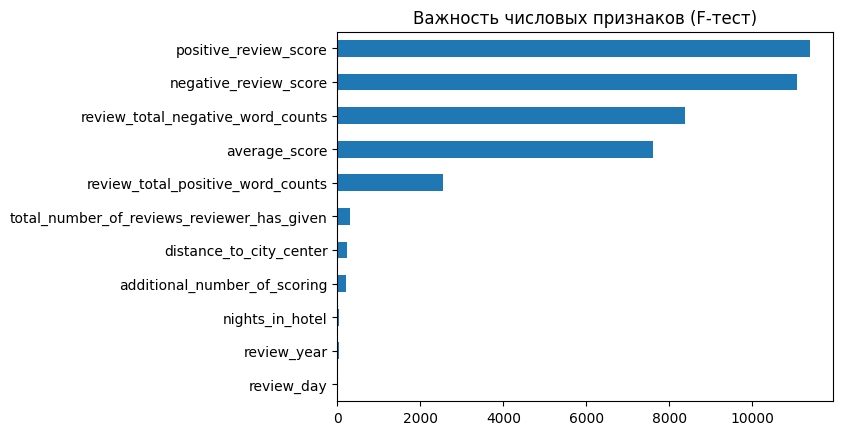

In [129]:
from sklearn.feature_selection import f_classif

# 1. Анализ значимости числовых признаков через f_classif
f_values, p_values = f_classif(X[num_features], y)
imp_num = pd.Series(f_values, index=num_features)
imp_num.sort_values(inplace=True)

# 2. Визуализация важности числовых признаков
imp_num.plot(kind='barh') # Тип графика
plt.title("Важность числовых признаков (F-тест)") # Название графика
plt.show() # Показываем 

In [131]:
# Установим порог 
threshold_num = imp_num.median()

# Выберем только те признаки, которые не превышают порог
num_features_to_drop = imp_num[imp_num < threshold_num].index
num_features_to_drop

Index(['review_day', 'review_year', 'nights_in_hotel',
       'additional_number_of_scoring', 'distance_to_city_center'],
      dtype='object')

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2.

Метод возвращает массив значений хи-квадрат и p-value для каждого признака.

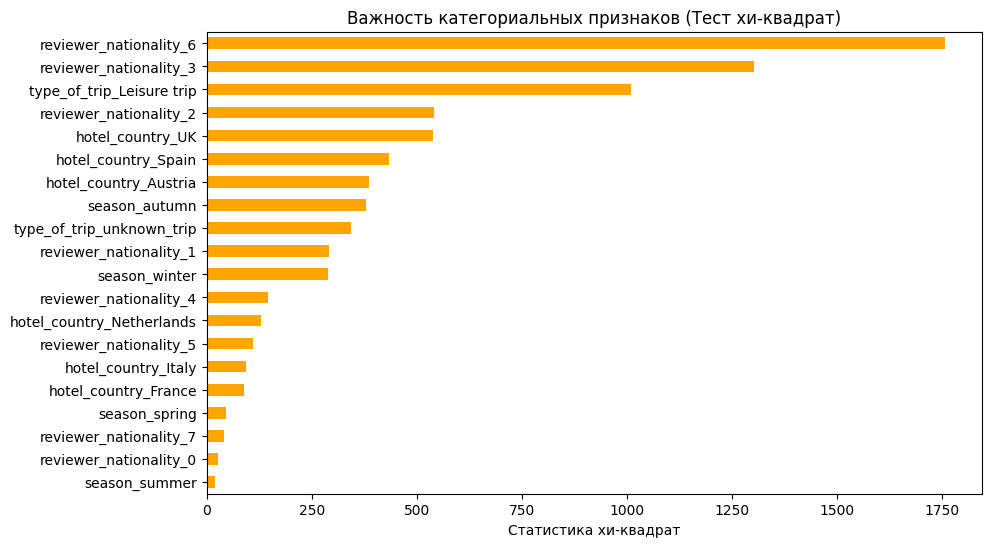

In [132]:
# Исмпортируем библиотеку
from sklearn.feature_selection import chi2

# Создаем серию для отображения важности признаков
imp_cat = pd.Series(chi2(X[cat_features], y)[0], index=cat_features)
imp_cat.sort_values(inplace=True)

# Визуализируем результаты
fig, ax = plt.subplots(figsize=(10, 6))
imp_cat.plot(kind='barh', color='orange', ax=ax)
ax.set_title("Важность категориальных признаков (Тест хи-квадрат)")
plt.xlabel('Статистика хи-квадрат')
plt.show()


Установим порог в "медиану" по значениям из серии

In [133]:
threshold_cat = imp_cat.median()

Удалим признаки, которые меньше порога

In [134]:
cat_features_to_drop = imp_cat[imp_cat <= threshold_cat].index
cat_features_to_drop

Index(['season_summer', 'reviewer_nationality_0', 'reviewer_nationality_7',
       'season_spring', 'hotel_country_France', 'hotel_country_Italy',
       'reviewer_nationality_5', 'hotel_country_Netherlands',
       'reviewer_nationality_4', 'season_winter'],
      dtype='object')

Соединим категориальные и числовые признаки для удаления 

In [135]:
features_to_drop = list(num_features_to_drop) + list(cat_features_to_drop)

Удалим признаки в исходном дф

In [136]:
hotels.drop(columns=features_to_drop, inplace=True)

In [137]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   dataset                                     515738 non-null  int64  
 6   negative_review_score                       515738 non-null  float64
 7   positive_review_score                       515738 non-null  float64
 8   season_autumn                               515738 non-null  int64  
 9   hotel_country_UK                            515738 non-null  int64  
 

На данном этапе осталось 15 числовых признаков(не считавая таргет и признак-метку)

# 6. Создание и обучение модели

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)

In [138]:
train_data = hotels.query('dataset == 1').drop(['dataset'], axis=1)
test_data = hotels.query('dataset == 0').drop(['dataset'], axis=1)

y = train_data['reviewer_score'].values
X = train_data.drop('reviewer_score', axis=1)

In [139]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [140]:
# Проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((290102, 16), (96701, 16), (290102,), (96701,))

In [141]:
# Импортируем библиотеку
from sklearn.ensemble import RandomForestRegressor

# Создаем модель
model = RandomForestRegressor(n_estimators=500, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


# Обучаем модель на обучаещем наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
Предсказанные значения записываем в переменную y_pred 

In [142]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.6s finished


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.

In [144]:
# Импортируем бибилотеку для рассчета MAPE
from sklearn.metrics import mean_absolute_percentage_error

# Считаем MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape * 100:.2f}%")

MAPE: 12.50%


<Axes: >

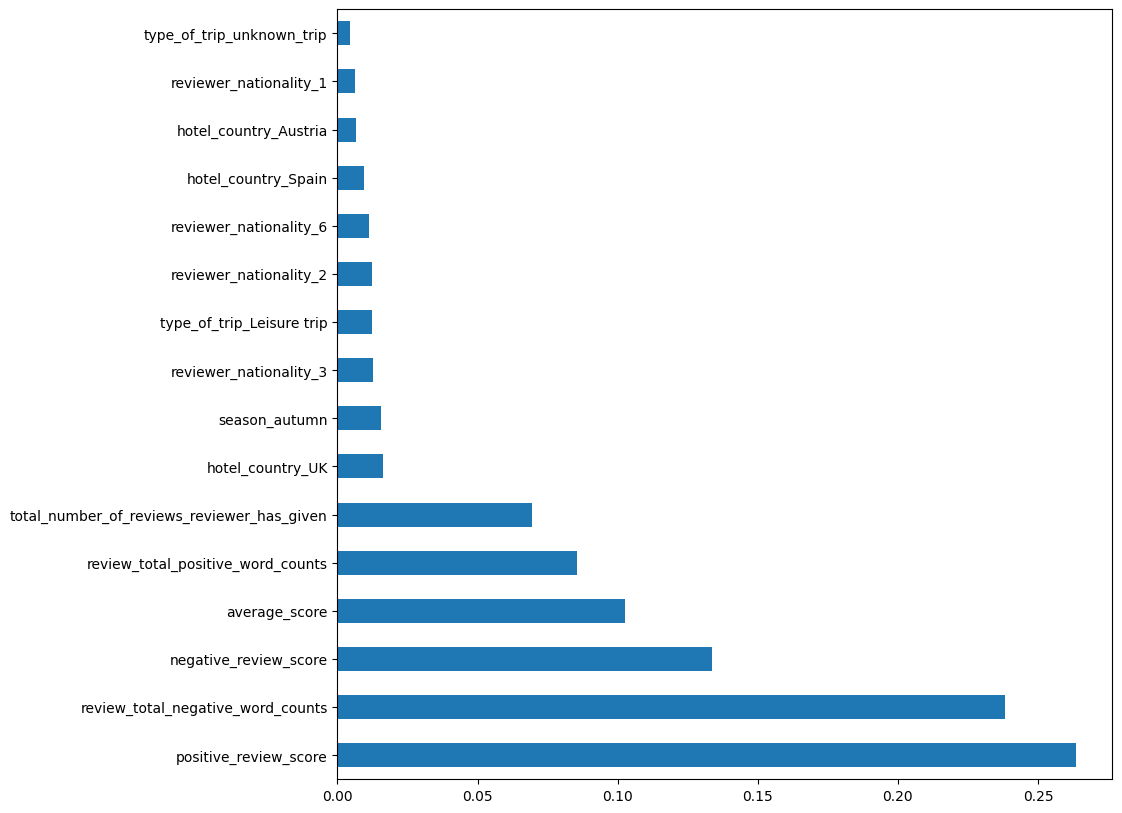

In [143]:
# Посмотрим на самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

В ТОП-5 признаков можно увидеть два признака которые мы создали при обработке данных. В целом при обучении использовалось 11 из 15 признаков, которые были созданы вручную

In [145]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [146]:
test_data

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,negative_review_score,positive_review_score,season_autumn,hotel_country_UK,hotel_country_Austria,hotel_country_Spain,type_of_trip_Leisure trip,type_of_trip_unknown_trip,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_6
386803,8.1,52,62,1,0.0,-0.354,0.962,0,0,0,0,1,0,0,0,0,0
386804,8.6,10,0,7,0.0,-0.691,-1.000,0,0,0,0,1,0,0,1,1,0
386805,8.3,3,5,15,0.0,-0.542,0.691,1,0,0,1,0,0,0,0,0,1
386806,9.1,0,27,9,0.0,1.000,1.000,1,0,0,0,1,0,0,0,0,0
386807,9.1,0,7,2,0.0,1.000,0.772,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,8.1,0,4,14,0.0,1.000,0.421,0,0,0,0,0,0,0,1,1,1
515734,7.8,0,24,1,0.0,1.000,0.917,0,0,0,1,1,0,0,0,0,0
515735,8.0,31,23,1,0.0,-0.421,0.762,0,0,1,0,0,0,0,1,0,1
515736,9.0,0,20,7,0.0,1.000,0.839,0,0,0,0,1,0,0,1,0,0


Удаляем таргетный признак из тестовую выборки

In [147]:
test_data.drop('reviewer_score', axis=1, inplace=True)

In [148]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   16.0s finished


In [149]:
predict_submission

array([8.7002    , 7.53483   , 7.678     , ..., 7.8274    , 9.6506    ,
       6.66827429], shape=(128935,))

In [152]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('results/submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.700200,488440
1,7.534830,274649
2,7.678000,374688
3,9.820667,404352
4,9.454200,451596
5,8.462000,302161
6,7.765400,317079
7,7.581000,13963
8,8.505203,159785
9,7.633400,195089


В нормализации или стандартизации данных не увидел смысла, поэтому решил не применять ее.

# Вывод:

Проект демонстрирует процесс анализа данных, создания новых признаков, отбора значимых переменных и построения модели машинного обучения для прогнозирования рейтинга отелей. В обучении модели использовались признаки, которые были созданы при разведовательном анализе данных, а именно 11 признаков из 16. MAPE составил 12,5%, что удовлетворяет заданию. 
Полученная модель показывает высокую точность и может быть использована для автоматической оценки рейтинга отелей на основе отзывов пользователей.